In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
def show_plot(fig, save_as=False):
    if save_as:
        fig.savefig(save_as, bbox_inches='tight')
    plt.show()

In [4]:
# Load images
left_img = cv2.imread('./../img/left.jpeg')  
right_img = cv2.imread('./../img/right.jpeg')  

# Convert to grayscale for keypoint detection
l_img_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
r_img_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

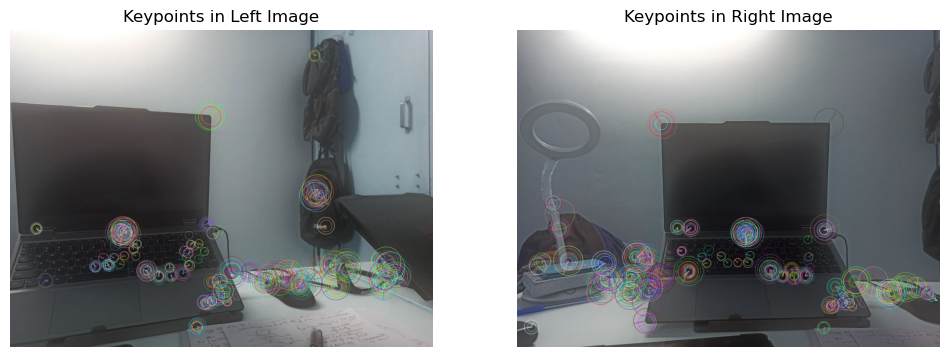

In [5]:
# Task 1: Show keypoints on both images
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(l_img_gray, None)
kp2, des2 = orb.detectAndCompute(r_img_gray, None)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cv2.drawKeypoints(left_img, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax[0].set_title("Keypoints in Left Image")
ax[0].axis('off')
ax[1].imshow(cv2.drawKeypoints(right_img, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax[1].set_title("Keypoints in Right Image")
ax[1].axis('off')
show_plot(fig, save_as="keypoints.png")

In [6]:
# Task 2: Compute Homography and display matrix
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
good_matches = [[kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1]] for m in matches]

def homography(points):
    A = []
    for pt in points:
        x, y = pt[0], pt[1]
        X, Y = pt[2], pt[3]
        A.append([x, y, 1, 0, 0, 0, -X*x, -X*y, -X])
        A.append([0, 0, 0, x, y, 1, -Y*x, -Y*y, -Y])
    A = np.array(A)
    _, _, vh = np.linalg.svd(A)
    H = vh[-1, :].reshape(3, 3)
    H /= H[2, 2]
    return H

H = homography(good_matches[:10])  # Compute homography with the first 10 good matches
print("Computed Homography Matrix:")
print(H)

Computed Homography Matrix:
[[ 4.92138766e-01 -1.40301265e+00  8.72615965e+02]
 [ 4.37430224e-01 -1.24801051e+00  7.76346342e+02]
 [ 5.62765933e-04 -1.60708578e-03  1.00000000e+00]]


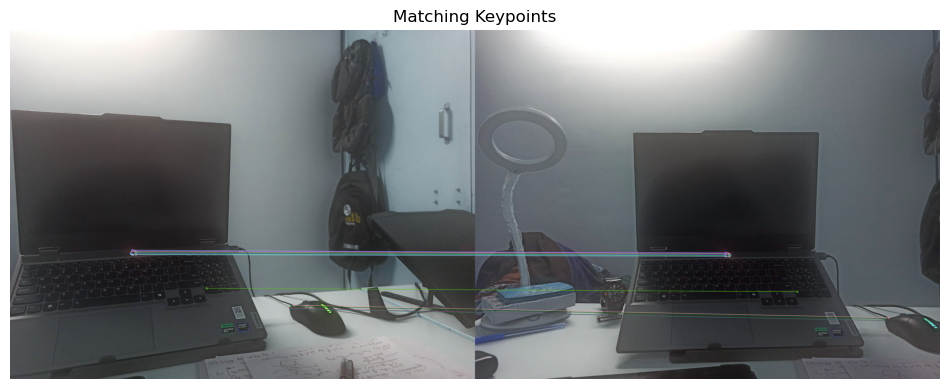

In [7]:
# Task 3: Show matching keypoints
match_img = cv2.drawMatches(left_img, kp1, right_img, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12, 6))
plt.imshow(match_img)
plt.title("Matching Keypoints")
plt.axis('off')
show_plot(plt.gcf(), save_as="matching_keypoints.png")

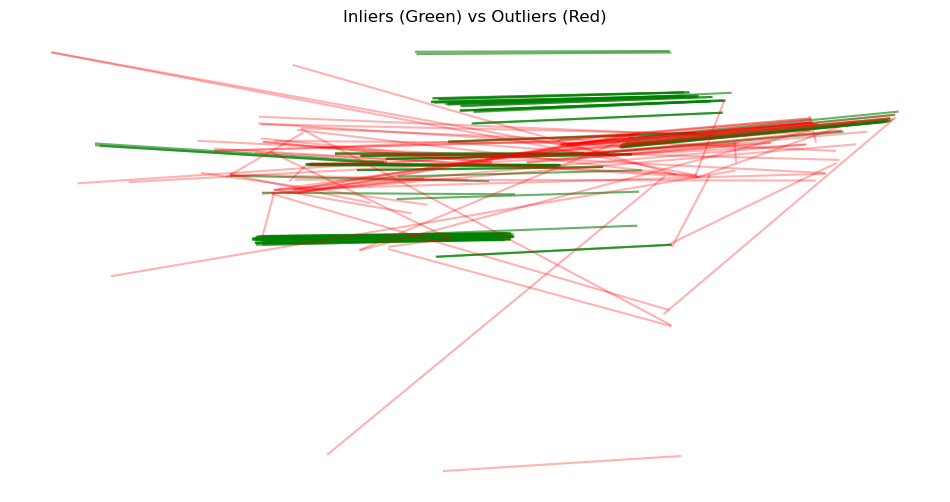

In [8]:
# Task 4: RANSAC for inliers/outliers
def ransac(good_pts, threshold=5, iterations=5000):
    best_inliers = []
    final_H = None
    for _ in range(iterations):
        random_pts = random.choices(good_pts, k=4)
        H = homography(random_pts)
        inliers = []
        for pt in good_pts:
            p = np.array([pt[0], pt[1], 1]).reshape(3, 1)
            p_1 = np.array([pt[2], pt[3], 1]).reshape(3, 1)
            Hp = np.dot(H, p)
            Hp /= Hp[2]
            dist = np.linalg.norm(p_1 - Hp)
            if dist < threshold:
                inliers.append(pt)
        if len(inliers) > len(best_inliers):
            best_inliers, final_H = inliers, H
    return final_H, best_inliers

final_H, inliers = ransac(good_matches)

outliers = [pt for pt in good_matches if pt not in inliers]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for pt in inliers:
    ax.plot([pt[0], pt[2]], [pt[1], pt[3]], 'g-', alpha=0.6)
for pt in outliers:
    ax.plot([pt[0], pt[2]], [pt[1], pt[3]], 'r-', alpha=0.3)
ax.set_title("Inliers (Green) vs Outliers (Red)")
ax.axis('off')
show_plot(fig, save_as="inliers_outliers.png")

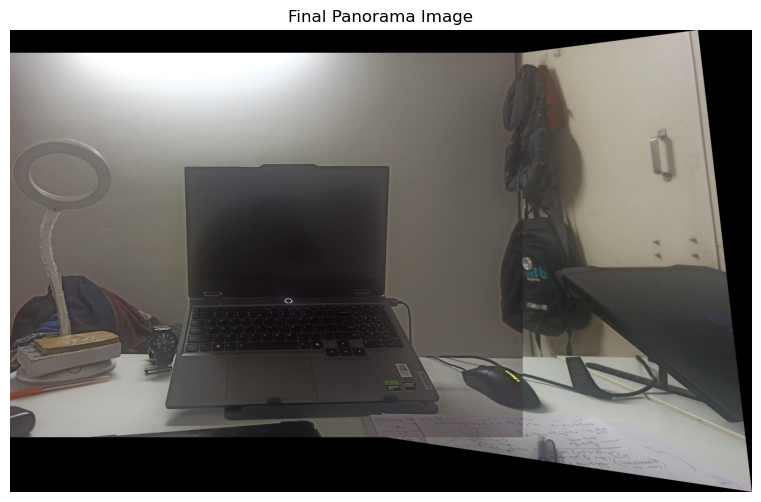

Panorama image saved successfully.


In [9]:
# Task 5: Generate final panorama
rows1, cols1 = right_img.shape[:2]
rows2, cols2 = left_img.shape[:2]
points1 = np.float32([[0, 0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
points2 = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)
transformed_points = cv2.perspectiveTransform(points2, final_H)
list_of_points = np.concatenate((points1, transformed_points), axis=0)
[x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
H_translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]]).dot(final_H)
output_img = cv2.warpPerspective(left_img, H_translation, (x_max - x_min, y_max - y_min))
output_img[-y_min:rows1 + (-y_min), -x_min:cols1 + (-x_min)] = right_img
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Final Panorama Image")
plt.axis('off')
show_plot(plt.gcf(), save_as="final_panorama.png")
cv2.imwrite('task2_result.jpg', output_img)
print("Panorama image saved successfully.")